In [9]:
%reset -f

import numpy as np
import pickle, time
import pandas as pd

from scipy import stats
import matplotlib.pyplot as plt

In [10]:
path = r'/home/d/dlr10/Documents/02_Statitics_modelling/DataSets/'
#df_patients_16_18, df_admissions_16_18, _ = load_fn.Load_data()
#df_patients_19_20, df_admissions_19_20, _ = load_fn.Load_data('2019_2020')

X_data_16_18 = pickle.load(open(path + 'df_ts_2016_18.pickle','rb'))
X_data_19_20 = pickle.load(open(path + 'df_ts_2019_20.pickle','rb'))

lst_admn_val = X_data_19_20['admission_id'].unique().tolist()
X_data_19_20.head(5)

,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,...,ALB,ALP,BILI,no_sample_series,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,Mortality
0,70461223,17.000000,2.0,102.0,36.5,148.0,80.0,95.0,0.0,0.0,...,34.0,69.0,8.0,0,1.0,0.0,69.0,0.0,1.0,0.0
1,70461223,16.981981,2.0,101.711712,36.503604,147.765766,79.63964,95.018018,0.0,1.0,...,34.0,69.0,8.0,1,1.0,0.0,69.0,0.0,1.0,0.0
2,70461223,16.963964,2.0,101.423423,36.507207,147.531532,79.279279,95.036036,0.0,1.0,...,34.0,69.0,8.0,2,1.0,0.0,69.0,0.0,1.0,0.0
3,70461223,16.945946,2.0,101.135135,36.510811,147.297297,78.918919,95.054054,0.0,1.0,...,34.0,69.0,8.0,3,1.0,0.0,69.0,0.0,1.0,0.0
4,70461223,16.927927,2.0,100.846847,36.514414,147.063063,78.558559,95.072072,0.0,1.0,...,34.0,69.0,8.0,4,1.0,0.0,69.0,0.0,1.0,0.0


# Functions

In [11]:
def measure_difference(row, feature, scaling, error):
    admn    = row['admission_id']
    mse_val = row[error]

    df_admn = X_data_19_20[X_data_19_20['admission_id'] == admn]

    if scaling == "global":
        min_val = dict_sypmt_min_max[feature][0]
        max_val = dict_sypmt_min_max[feature][1]
    else:
        min_val = df_admn[feature].min()
        max_val = df_admn[feature].max()

    if min_val == max_val:
        predict_val_1 = (mse_val *(max_val)) + min_val
        predict_val_2 = (mse_val * 2 *(max_val)) + min_val

    else:
        predict_val_1 = (mse_val *(max_val - min_val)) + min_val
        predict_val_2 = (mse_val * 2 * (max_val - min_val)) + min_val
    m_diff = predict_val_2 -predict_val_1
    return m_diff
# ---------------------------------------------------
# ====================================================
# ====================================================
# ====================================================
def load_results(features, scaling, technique):
    t = time.time()
    cols_res = ['admission_id', 'mse_0', 'mse_l', 'acc', 'y_pred']
    dict_df = {}
    for feat_pos,feature in enumerate(features):
        if scaling == "global":
            file_path = 'Results/'+feature+'_'+ technique +'_forecasting_results.pickle'
        else:
            file_path = "Results_3/Results"+'/'+feature+'_'+ technique +'_forecasting_results.pickle'

        results_feat = pd.DataFrame(pickle.load(open(file_path,'rb'))[0], columns = cols_res)
        results_feat['diff_0'] = results_feat.apply(lambda x: measure_difference(x, feature, scaling, 'mse_0'), axis = 1)
        results_feat['diff_l'] = results_feat.apply(lambda x: measure_difference(x, feature, scaling, 'mse_l'), axis = 1)
        dict_df[feature] = results_feat
        accuracy = sum(dict_df[feature]['acc']) / len(dict_df['rr'])
        print(feature, len(results_feat), '{:.2f}'.format(accuracy))
    print("Elapsed time:", time.time()-t)
    return dict_df

# ---------------------------------------------------
# ====================================================
# ====================================================
# ====================================================
def compute_CURB65(adm_age, adm_rr, adm_urea, adm_sbp, adm_dbp):
    CURB_score = 0
    if adm_age  >= 65: CURB_score = CURB_score + 1
    #if adm_conf >= 8: CURB_score = CURB_score + 1
    if adm_rr   >= 30: CURB_score = CURB_score + 1
    if adm_urea >= 7: CURB_score = CURB_score + 1
    if (adm_sbp <= 90) or (adm_dbp <= 60): CURB_score = CURB_score + 1
    return CURB_score
                                                                                                                         
# ---------------------------------------------------
# ====================================================
# ====================================================
# ====================================================                                                                                                                        
                                                                                                                         

def back_engineer_series(dict_df, scaling, technique, features):
    t = time.time()
    cols_df = ['admission_id', 'Age']
    df_final = []
    dict_sypmt_min_max = {'rr':[5, 40], 'heart_rate':[20,160], 'temperature':[34, 40],'sbp': [60,200], 'dbp':[40,120],
                     'Oxygen_Saturation':[60,100], 'ews':[0,21], 'UREA':[0.5, 30]}
    for x in  [[feature +' real', feature + ' pred'] for feature in features]: cols_df.extend(x)

    for idx, admn in enumerate (lst_admn_val):

        row = []
        row.append(admn)

        df_admn = X_data_19_20[X_data_19_20['admission_id'] == admn]
        row.append(df_admn['age_at_admin'].mean())


        for feat_pos,feature in enumerate(features):
            real_val = df_admn[feature].tolist()[-1]
            last_val = list(dict_df[feature][dict_df[feature]['admission_id'] == admn]['y_pred'].values[0])[-1]

            if scaling == "global":
                min_val = dict_sypmt_min_max[feature][0]
                max_val = dict_sypmt_min_max[feature][1]
            else:
                min_val = df_admn[feature].min()
                max_val = df_admn[feature].max()


            if min_val == max_val:
                predict_val = (last_val *(max_val)) + min_val
            else:
                predict_val = (last_val *(max_val - min_val)) + min_val

            row = row + [real_val, predict_val]
        df_final.append(row)


    df_final = pd.DataFrame(df_final, columns = cols_df)
    df_final['CURB_real'] = df_final.apply(lambda x: compute_CURB65(x['Age'], x['rr real'], x['UREA real'], x['sbp real'], x['dbp real']), axis = 1)
    df_final['CURB_pred'] = df_final.apply(lambda x: compute_CURB65(x['Age'], x['rr pred'], x['UREA pred'], x['sbp pred'], x['dbp pred']), axis = 1)
    #print(admn, min_val, max_val, last_val, predict_val)
    display(df_final.head(10))
    print("Elapsed time:", time.time()-t)
    return df_final

____________________________________
____________________________________
____________________________________

In [12]:
features = ['rr', 'UREA', 'sbp','dbp']
cols_res = ['admission_id', 'mse_0', 'mse_l', 'acc', 'y_pred']

In [5]:
# ---------------------------------------------------
# LOAD ALL THE DF WITH THE RESULTS AND STORE THEM IN A DICTIONARY WITH FEATURE AS KEY
# ---------------------------------------------------

print('---------------------------------------------------')
print("dict_df_local_GRU")
dict_df_local_GRU  = load_results(features, "local", "BOGRU")
pickle.dump(dict_df_local_GRU, open('dict_df_local_GRU.pickle', 'wb'))

---------------------------------------------------
dict_df_local_GRU
rr 7892 0.58
UREA 7892 0.66
sbp 7892 0.46
dbp 7892 0.50
Elapsed time: 5904.038264274597


In [47]:
print('---------------------------------------------------')
print("dict_df_local_LSTM")
dict_df_local_LSTM = load_results(features, "local", "BOLSTM")
pickle.dump(dict_df_local_LSTM, open('dict_df_local_LSTM.pickle', 'wb'))

---------------------------------------------------
dict_df_local_LSTM
rr 7892 0.55
UREA 7892 0.66
sbp 7892 0.46
dbp 7892 0.47
Elapsed time: 6160.885043859482


In [48]:
dict_sypmt_min_max = {'rr':[5, 40], 'heart_rate':[20,160], 'temperature':[30, 45],'sbp': [60,200], 
                      'dbp':[40,120], 'Oxygen_Saturation':[60,100], 'ews':[0,21], 'CREA':[20, 600], 
                      'UREA':[0.5, 30],'K':[2,7],'GFR':[20, 200],'WBC':[3, 55]}
print('---------------------------------------------------')
print("dict_df_global_GRU")
dict_df_global_GRU  = load_results(features, "global", "BOGRU")
pickle.dump(dict_df_global_GRU, open('dict_df_global_GRU.pickle', 'wb'))

---------------------------------------------------
dict_df_global_GRU
rr 7892 0.68
UREA 7892 0.41
sbp 7892 0.46
dbp 7892 0.48
Elapsed time: 4525.689079523087


In [49]:
print('---------------------------------------------------')
print("dict_df_global_LSTM")
dict_df_global_LSTM = load_results(features, "global", "BOLSTM")
pickle.dump(dict_df_global_LSTM, open('dict_df_global_LSTM.pickle', 'wb'))

---------------------------------------------------
dict_df_global_LSTM
rr 7892 0.50
UREA 7892 0.43
sbp 7892 0.44
dbp 7892 0.48
Elapsed time: 4522.7968990802765


In [9]:
display( dict_df_local_GRU['rr'].head(3))
display( dict_df_local_LSTM['rr'].head(3))

,admission_id,mse_0,mse_l,acc,y_pred,diff_0,diff_l
0,70461223.0,0.234944,0.095447,1,"[0.6097103, 0.65570974, 0.6652219, 0.6254992, ...",1.879552,0.763576
1,19488170.0,0.400079,0.052796,1,"[0.36748174, 0.359825, 0.355893, 0.35167906, 0...",2.800555,0.369571
2,89219346.0,0.031809,0.020075,1,"[0.56471306, 0.5888791, 0.61739194, 0.6138429,...",0.246984,0.155875


,admission_id,mse_0,mse_l,acc,y_pred,diff_0,diff_l
0,70461223.0,0.238518,0.050045,1,"[0.61338276, 0.60879123, 0.6204542, 0.61194783...",1.908142,0.400362
1,19488170.0,0.386501,0.095125,0,"[0.37830782, 0.36344504, 0.3578628, 0.35021496...",2.705508,0.665872
2,89219346.0,0.029709,0.003882,0,"[0.5587277, 0.5736399, 0.56955075, 0.57566494,...",0.230684,0.030143


____________________________________________________________
____________________________________________________________
____________________________________________________________


In [7]:
# ---------------------------------------------------
# Back engineer the last value of every feature prediction. and compute CURB65
# ---------------------------------------------------

#dict_df = dict_df_local_GRU.copy()
#scaling = "local"
#technique = "GRU"
#features = ['rr', 'UREA', 'sbp','dbp']

dict_df_local_GRU   = pickle.load(open('dict_df_local_GRU.pickle','rb'))
dict_df_local_LSTM  = pickle.load(open('dict_df_local_LSTM.pickle','rb'))

print('---------------------------------------------------')
print("dict_df_local_GRU")
df_final_local_GRU  = back_engineer_series(dict_df_local_GRU, "local", "BOGRU", features)
print('---------------------------------------------------')
print("dict_df_local_LSTM")
df_final_local_LSTM  = back_engineer_series(dict_df_local_LSTM, "local", "BOLSTM", features)

---------------------------------------------------
dict_df_local_GRU


,admission_id,Age,rr real,rr pred,UREA real,UREA pred,sbp real,sbp pred,dbp real,dbp pred,CURB_real,CURB_pred
0,70461223,69.0,23.913313,18.624712,3.100000,3.093713,119.563467,127.900239,65.130031,63.495821,1,1
1,19488170,77.0,16.820513,17.108414,3.800000,3.802822,149.487179,132.818675,77.743590,72.727531,1,1
2,89219346,60.0,21.666666,18.957289,17.875000,17.989023,125.500000,134.170638,73.500000,74.262954,1,1
3,18991471,74.0,16.000000,17.192892,9.100000,9.109791,134.909091,130.009409,86.818182,72.654390,2,2
4,47048263,75.0,21.181818,22.532568,11.261538,11.327340,119.136364,120.851199,70.590909,71.301733,2,2
5,68724460,61.0,18.000000,17.128344,5.700000,5.698812,113.105263,100.824797,75.421053,67.540885,0,0
6,97758575,57.0,18.000000,18.837994,7.112500,7.086708,120.210526,120.664097,74.210526,78.170009,1,1
7,12218062,69.0,23.444445,20.337307,14.800000,14.766437,125.888889,115.047984,76.000000,69.719864,2,2
8,24970489,77.0,18.750000,19.841476,30.000000,30.104916,131.500000,142.412706,68.500000,68.670515,2,2
9,86509892,63.0,18.000000,15.603897,5.550000,5.558906,112.062500,109.911917,64.250000,74.013853,0,0


Elapsed time: 522.3066310882568
---------------------------------------------------
dict_df_local_LSTM


,admission_id,Age,rr real,rr pred,UREA real,UREA pred,sbp real,sbp pred,dbp real,dbp pred,CURB_real,CURB_pred
0,70461223,69.0,23.913313,17.942818,3.100000,3.097887,119.563467,122.363899,65.130031,65.363968,1,1
1,19488170,77.0,16.820513,17.658958,3.800000,3.798742,149.487179,134.364301,77.743590,72.675142,1,1
2,89219346,60.0,21.666666,17.373356,17.875000,17.993893,125.500000,134.091582,73.500000,74.756897,1,1
3,18991471,74.0,16.000000,17.785126,9.100000,9.112563,134.909091,127.911884,86.818182,72.188113,2,2
4,47048263,75.0,21.181818,20.427513,11.261538,11.367206,119.136364,119.197779,70.590909,71.652863,2,2
5,68724460,61.0,18.000000,17.068914,5.700000,5.700778,113.105263,102.080764,75.421053,66.920052,0,0
6,97758575,57.0,18.000000,19.198933,7.112500,7.204698,120.210526,121.161778,74.210526,77.252262,1,1
7,12218062,69.0,23.444445,20.550434,14.800000,14.799341,125.888889,115.217052,76.000000,71.303804,2,2
8,24970489,77.0,18.750000,19.169903,30.000000,29.975497,131.500000,141.811210,68.500000,71.570551,2,2
9,86509892,63.0,18.000000,16.476040,5.550000,5.552025,112.062500,110.906794,64.250000,73.658819,0,0


Elapsed time: 520.348539352417


In [8]:
dict_df_global_GRU   = pickle.load(open('dict_df_global_GRU.pickle','rb'))
dict_df_global_LSTM  = pickle.load(open('dict_df_global_LSTM.pickle','rb'))

print('---------------------------------------------------')
print("dict_df_global_GRU")
df_final_global_GRU  = back_engineer_series(dict_df_global_GRU, "global", "BOGRU", features)
print('---------------------------------------------------')
print("dict_df_global_LSTM")
df_final_global_LSTM  = back_engineer_series(dict_df_global_LSTM, "global", "BOLSTM", features)

---------------------------------------------------
dict_df_global_GRU


,admission_id,Age,rr real,rr pred,UREA real,UREA pred,sbp real,sbp pred,dbp real,dbp pred,CURB_real,CURB_pred
0,70461223,69.0,23.913313,17.827499,3.100000,4.413336,119.563467,131.293012,65.130031,69.110219,1,1
1,19488170,77.0,16.820513,17.986609,3.800000,3.684040,149.487179,122.970283,77.743590,71.199274,1,1
2,89219346,60.0,21.666666,17.347093,17.875000,17.748446,125.500000,126.197155,73.500000,70.229459,1,1
3,18991471,74.0,16.000000,17.654059,9.100000,11.528641,134.909091,116.039717,86.818182,73.282068,2,2
4,47048263,75.0,21.181818,19.718589,11.261538,10.827862,119.136364,121.835018,70.590909,75.405786,2,2
5,68724460,61.0,18.000000,17.319298,5.700000,5.336211,113.105263,106.461319,75.421053,65.637279,0,0
6,97758575,57.0,18.000000,18.573850,7.112500,6.508631,120.210526,119.526533,74.210526,77.890210,1,0
7,12218062,69.0,23.444445,20.909298,14.800000,18.779334,125.888889,113.902740,76.000000,70.892084,2,2
8,24970489,77.0,18.750000,19.395257,30.000000,21.887276,131.500000,134.857813,68.500000,70.503249,2,2
9,86509892,63.0,18.000000,17.161834,5.550000,4.857511,112.062500,111.536047,64.250000,69.294012,0,0


Elapsed time: 525.027398109436
---------------------------------------------------
dict_df_global_LSTM


,admission_id,Age,rr real,rr pred,UREA real,UREA pred,sbp real,sbp pred,dbp real,dbp pred,CURB_real,CURB_pred
0,70461223,69.0,23.913313,18.005746,3.100000,4.581142,119.563467,131.794150,65.130031,70.017660,1,1
1,19488170,77.0,16.820513,18.164830,3.800000,3.850249,149.487179,122.105435,77.743590,70.497532,1,1
2,89219346,60.0,21.666666,17.689257,17.875000,17.768174,125.500000,127.112547,73.500000,72.435105,1,1
3,18991471,74.0,16.000000,18.003007,9.100000,11.356901,134.909091,114.295573,86.818182,73.442895,2,2
4,47048263,75.0,21.181818,19.268990,11.261538,11.237858,119.136364,122.345152,70.590909,76.259470,2,2
5,68724460,61.0,18.000000,17.857043,5.700000,5.489265,113.105263,105.804837,75.421053,66.776001,0,0
6,97758575,57.0,18.000000,18.584349,7.112500,6.804280,120.210526,119.708918,74.210526,79.748824,1,0
7,12218062,69.0,23.444445,19.835096,14.800000,19.338093,125.888889,113.517784,76.000000,70.586295,2,2
8,24970489,77.0,18.750000,19.475546,30.000000,22.592786,131.500000,135.168726,68.500000,69.640882,2,2
9,86509892,63.0,18.000000,17.680915,5.550000,4.978414,112.062500,112.350514,64.250000,70.419853,0,0


Elapsed time: 519.9565985202789


____________________________________________________________
____________________________________________________________
____________________________________________________________

# Tabular results 

In [7]:
import matplotlib
import seaborn as sns
from sklearn import metrics
import pickle, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['mathtext.fontset'] = 'cm'

In [13]:

dict_df_local_GRU   = pickle.load(open('dict_df_local_GRU.pickle','rb'))
dict_df_local_LSTM  = pickle.load(open('dict_df_local_LSTM.pickle','rb'))
dict_df_global_GRU   = pickle.load(open('dict_df_global_GRU.pickle','rb'))
dict_df_global_LSTM  = pickle.load(open('dict_df_global_LSTM.pickle','rb'))


df_dicts = [dict_df_local_GRU, dict_df_local_LSTM , dict_df_global_GRU , dict_df_global_LSTM]
scalers  = ['local', 'local', 'global', 'global']
techniques = ['GRU', 'LSTM', 'GRU', 'LSTM'] 


t = time.time()
df_results = []
for i in range(len(scalers)):
    df_dict = df_dicts[i]
    scaling = scalers[i]
    technique = techniques[i]
    

    for feature in features:
        row = [feature, scaling, technique]

        df_temp = df_dict[feature]
        for error in ['_0', '_l']:
            # Scale mse
            q3, q1  = np.percentile(df_temp['mse'+error], [75 ,25])
            med     = df_temp['mse'+error].median()
            # Representation of the mse
            q3_r, q1_r = np.percentile(df_temp['diff'+error], [75 ,25])
            rep_med    = df_temp['diff'+error].median()

            row = row + ["{:.3f}".format( med ),"{:.3f}".format( q1 ), "{:.3f}".format( q3 ), 
                        "{:.3f}".format( rep_med ),"{:.3f}".format( q1_r ), "{:.3f}".format( q3_r )]
        grad_acc = df_temp['acc'].sum()/len(df_temp)
        row.append("{:.3f}".format( grad_acc ))
        
        
        df_results.append(row)
df_results = pd.DataFrame(df_results, columns = ['Feature', 'Scale', 'Model', 
                                     'Med_0', 'q1_0', 'q3_0','rep_0', 'rep_q1_0', 'rep_q3_0',
                                     'Med_L', 'q1_L', 'q3_L','rep_L', 'rep_q1_L', 'rep_q3_L',
                                     'grad_acc'])
display(df_results.sort_values(by=['Feature', 'grad_acc']).reset_index(drop=True))
print("Elapsed", time.time()-t)
#df_results

,Feature,Scale,Model,Med_0,q1_0,q3_0,rep_0,rep_q1_0,rep_q3_0,Med_L,q1_L,q3_L,rep_L,rep_q1_L,rep_q3_L,grad_acc
0,UREA,global,GRU,0.003,0.000,0.010,0.076,0.013,0.284,0.001,0.000,0.002,0.017,0.003,0.071,0.411
1,UREA,global,LSTM,0.003,0.000,0.011,0.078,0.013,0.314,0.001,0.000,0.003,0.018,0.003,0.074,0.433
2,UREA,local,GRU,0.648,0.398,0.846,1.170,0.394,2.488,0.317,0.145,0.476,0.563,0.180,1.291,0.658
3,UREA,local,LSTM,0.655,0.419,0.864,1.197,0.412,2.524,0.320,0.145,0.481,0.570,0.183,1.291,0.663
4,dbp,local,LSTM,0.071,0.015,0.215,2.582,0.570,7.736,0.023,0.005,0.069,0.861,0.191,2.594,0.474
5,dbp,global,GRU,0.013,0.003,0.042,1.067,0.225,3.353,0.005,0.001,0.015,0.385,0.080,1.236,0.477
6,dbp,global,LSTM,0.011,0.002,0.036,0.906,0.196,2.893,0.004,0.001,0.014,0.344,0.071,1.143,0.482
7,dbp,local,GRU,0.072,0.016,0.220,2.644,0.592,7.985,0.023,0.005,0.068,0.843,0.180,2.553,0.495
8,rr,global,LSTM,0.003,0.001,0.023,0.120,0.028,0.811,0.001,0.000,0.002,0.025,0.005,0.076,0.505
9,rr,local,LSTM,0.158,0.032,0.448,0.985,0.223,3.227,0.018,0.003,0.064,0.126,0.023,0.425,0.552


Elapsed 0.08809828758239746


In [6]:
df_temp.columns


NameError: name 'df_temp' is not defined

=================== local GRU ===================


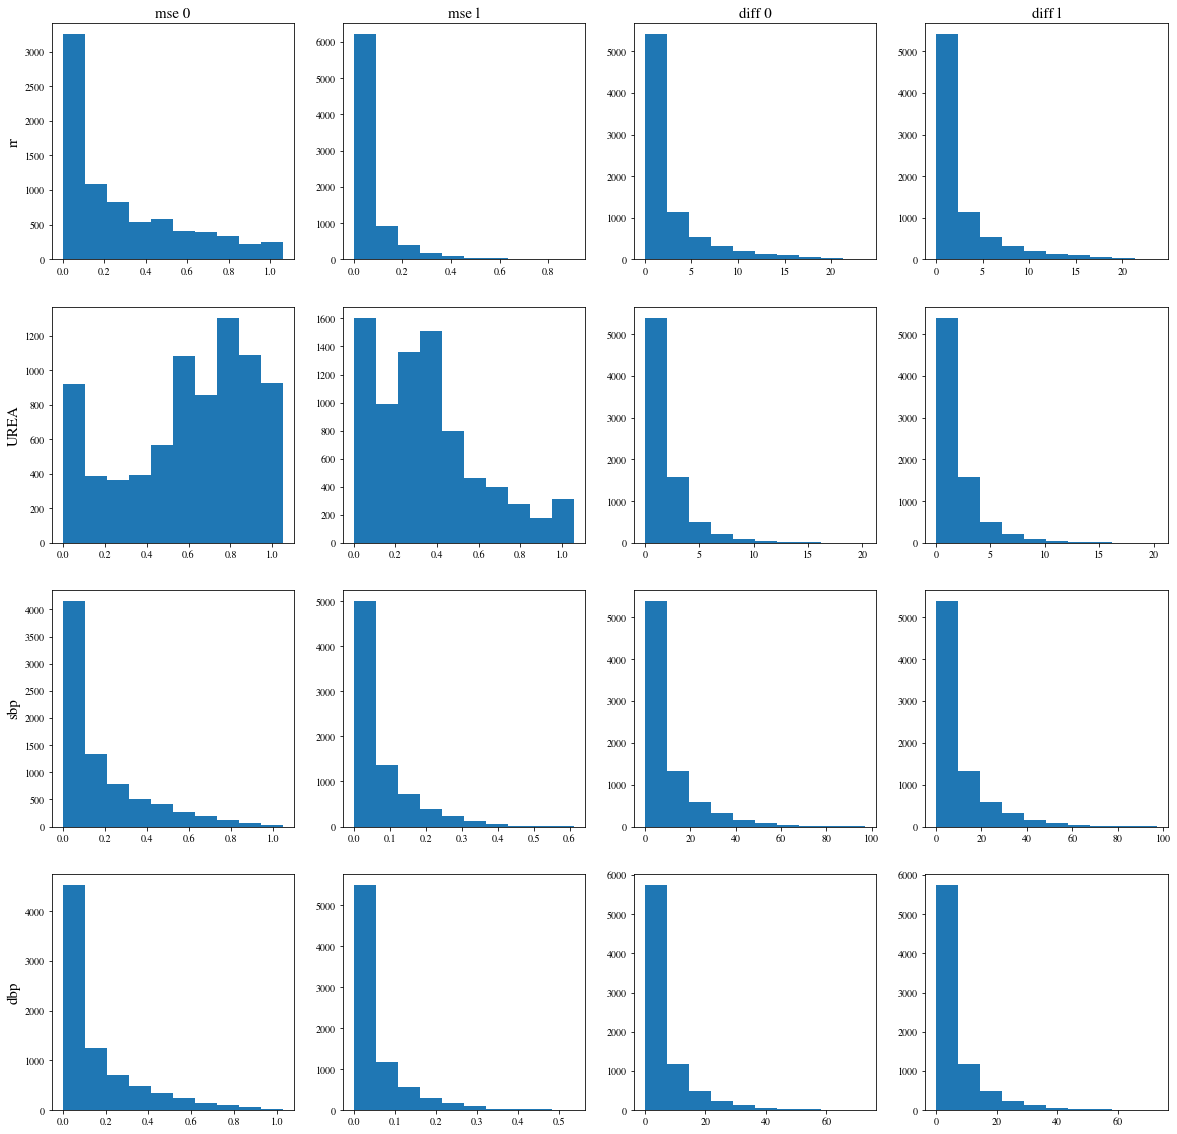

=================== local LSTM ===================


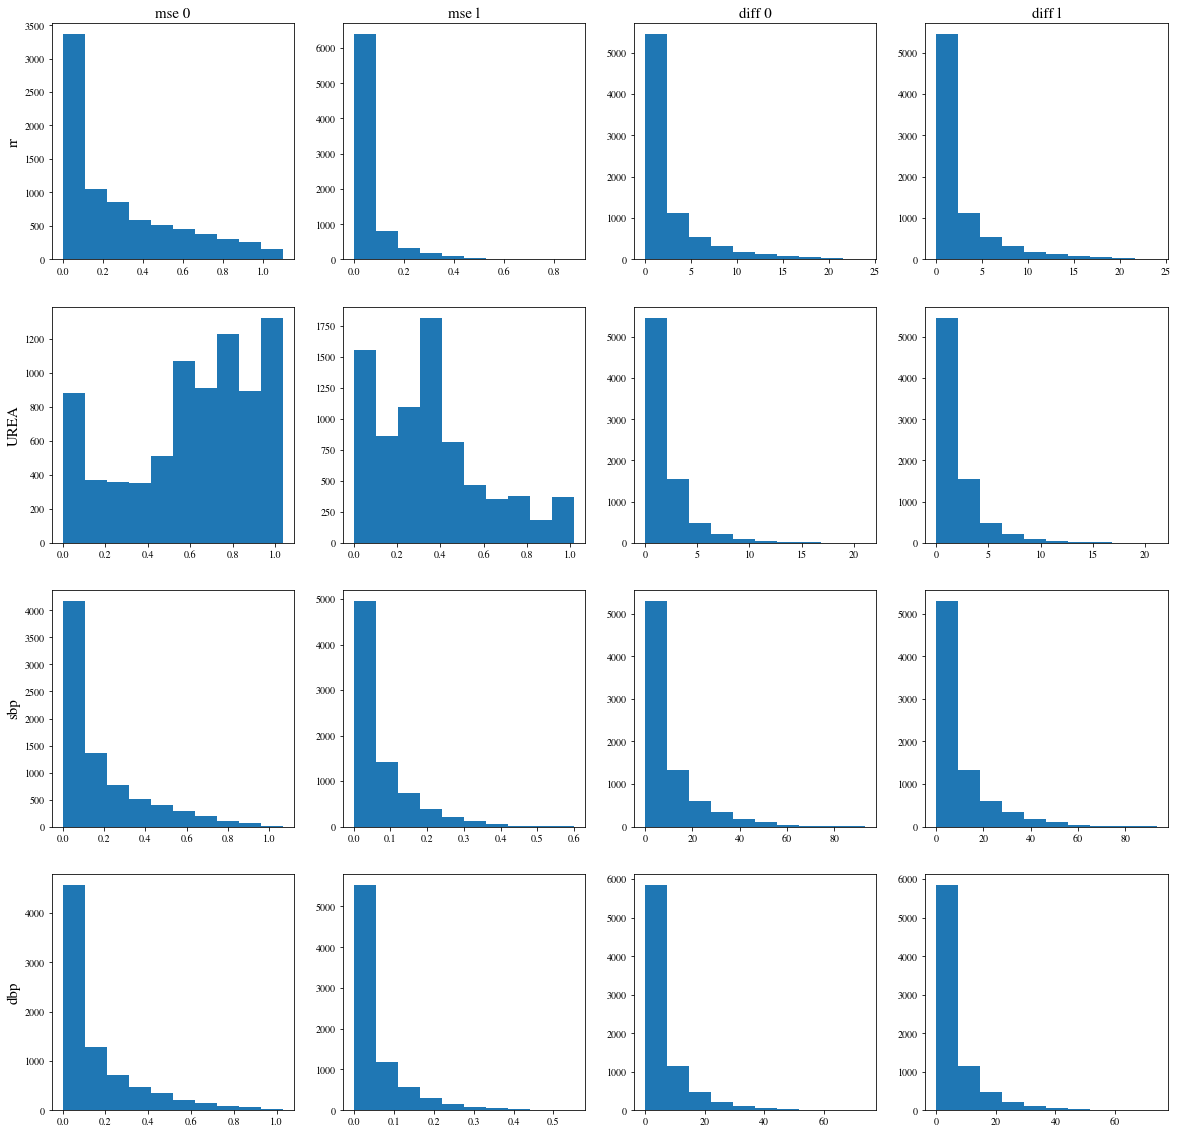

=================== global GRU ===================


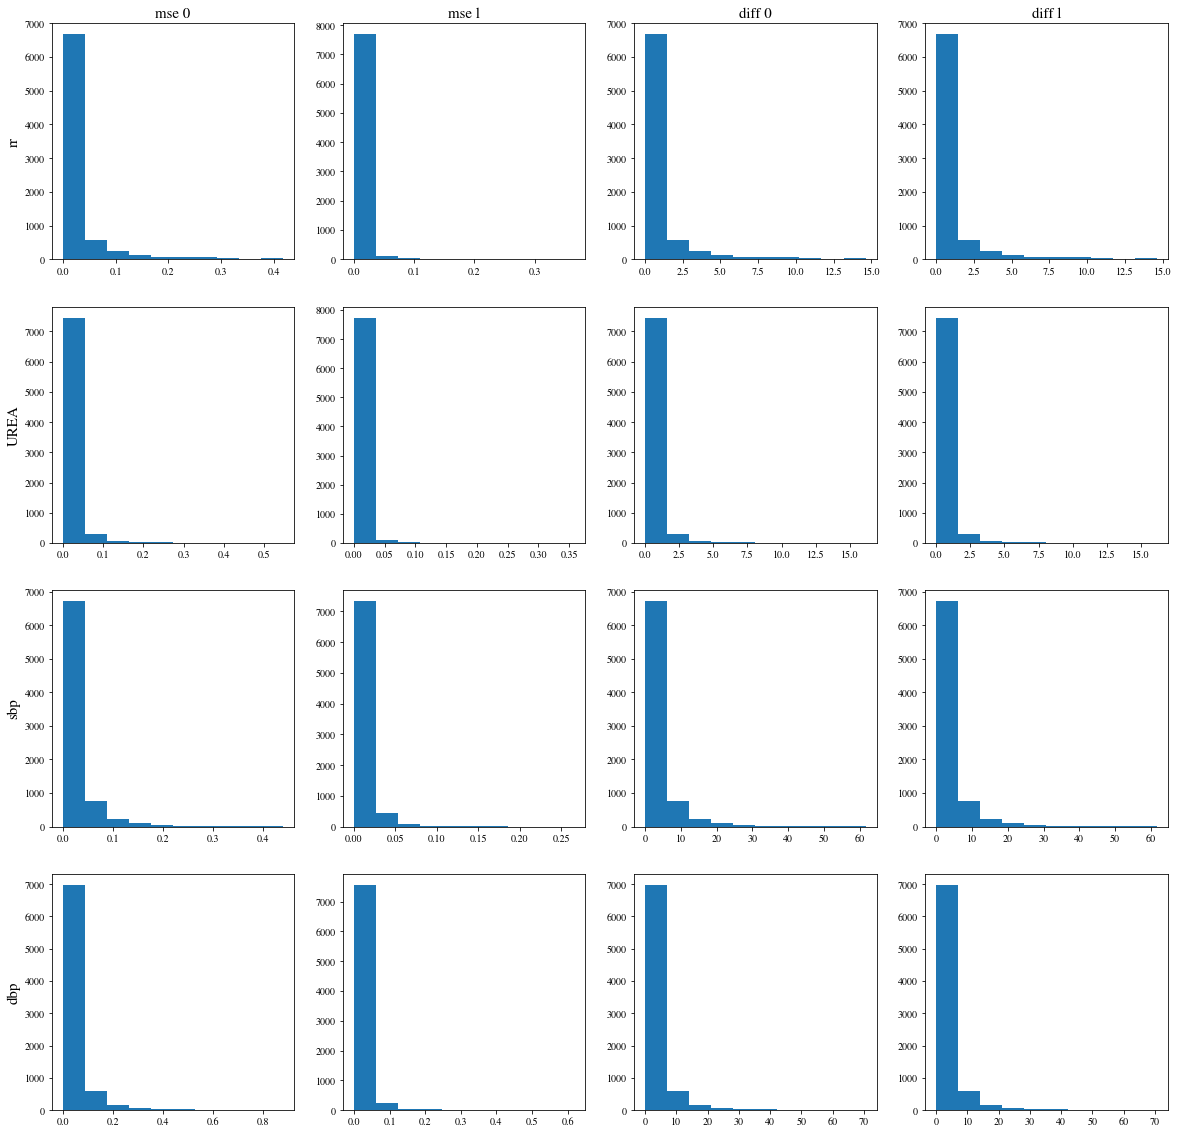

=================== global LSTM ===================


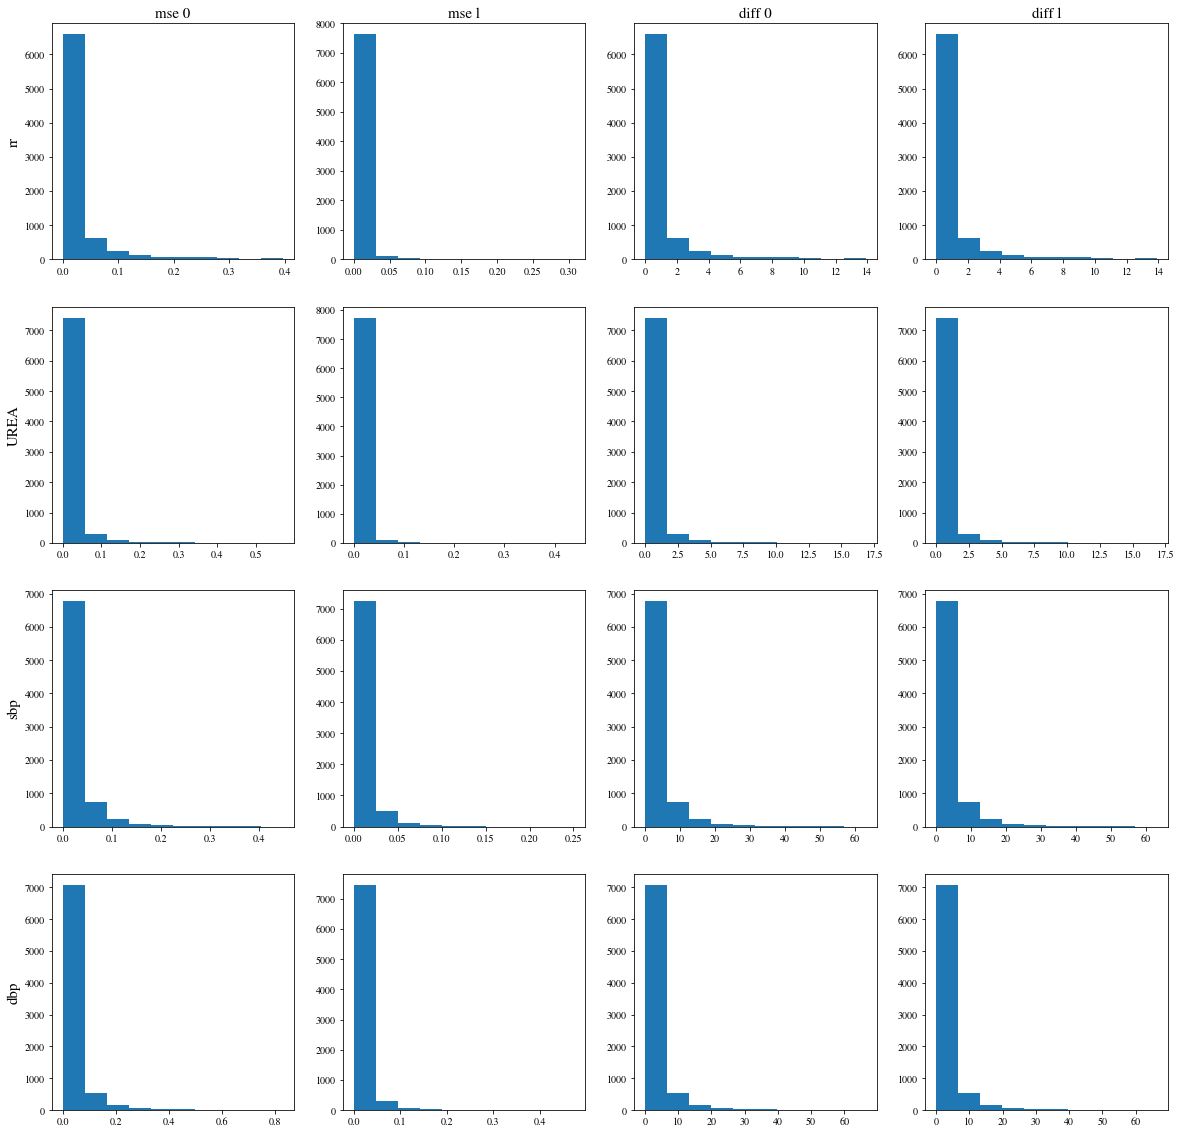

In [29]:
t = time.time()
df_results = []
for i in range(len(scalers)):
    df_dict = df_dicts[i]
    scaling = scalers[i]
    technique = techniques[i]
    print('===================', scaling, technique, '===================')
    fig, axs = plt.subplots(4,4, figsize = (20,20))
    for idx, feature in enumerate(features):
        
        row = [feature, scaling, technique]        
        df_temp = df_dict[feature]
        
        axs[idx, 0].hist(df_temp['mse_0'])
        axs[idx, 0].set_ylabel(feature, fontsize =15) 
        axs[idx, 1].hist(df_temp['mse_l'])
        axs[idx, 2].hist(df_temp['diff_0'])
        axs[idx, 3].hist(df_temp['diff_0'])
        if feature == 'rr':
            axs[idx, 0].set_title("mse 0", fontsize =15); axs[idx, 2].set_title("diff 0", fontsize =15)
            axs[idx, 1].set_title("mse l", fontsize =15); axs[idx, 3].set_title("diff l", fontsize =15)
    
    plt.show()

____________________________________
____________________________________
____________________________________

In [31]:
df_finals  = [df_final_local_GRU, df_final_local_LSTM, df_final_global_GRU, df_final_global_LSTM]
scalers    = ['local', 'local', 'global', 'global']
techniques = ['GRU', 'LSTM', 'GRU', 'LSTM'] 

df_finals[0].head(5)

,admission_id,Age,rr real,rr pred,UREA real,UREA pred,sbp real,sbp pred,dbp real,dbp pred,CURB_real,CURB_pred
0,70461223,69.0,23.913313,18.624712,3.100000,3.093713,119.563467,127.900239,65.130031,63.495821,1,1
1,19488170,77.0,16.820513,17.108414,3.800000,3.802822,149.487179,132.818675,77.743590,72.727531,1,1
2,89219346,60.0,21.666666,18.957289,17.875000,17.989023,125.500000,134.170638,73.500000,74.262954,1,1
3,18991471,74.0,16.000000,17.192892,9.100000,9.109791,134.909091,130.009409,86.818182,72.654390,2,2
4,47048263,75.0,21.181818,22.532568,11.261538,11.327340,119.136364,120.851199,70.590909,71.301733,2,2


In [34]:
df_finals[0]['CURB_pred'].unique()

array([1, 2, 0, 3, 4])

____________________________________
____________________________________
____________________________________

# Confusion Matrices

=================== local GRU ===================


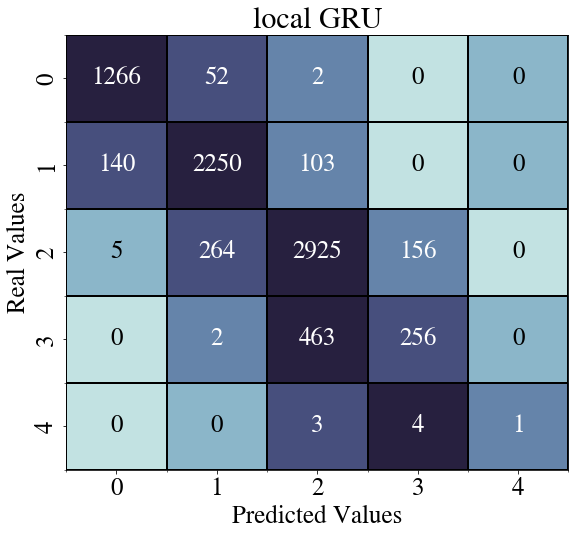

=================== local LSTM ===================


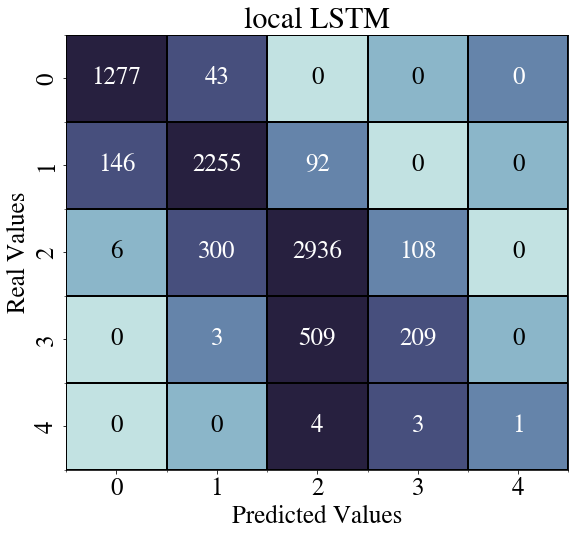

=================== global GRU ===================


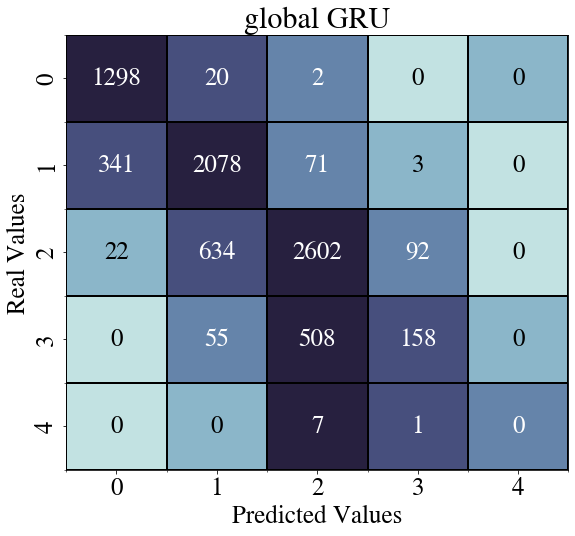

=================== global LSTM ===================


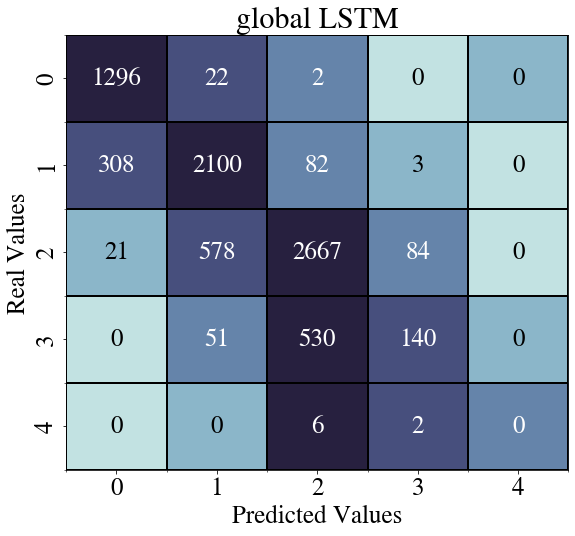

,0,1,2,3,4,type
0,1266,52,2,0,0,local_GRU
1,140,2250,103,0,0,local_GRU
2,5,264,2925,156,0,local_GRU
3,0,2,463,256,0,local_GRU
4,0,0,3,4,1,local_GRU
0,1277,43,0,0,0,local_LSTM
1,146,2255,92,0,0,local_LSTM
2,6,300,2936,108,0,local_LSTM
3,0,3,509,209,0,local_LSTM
4,0,0,4,3,1,local_LSTM


In [75]:
df_cm = pd.DataFrame(columns =['0','1','2','3','4', 'type'])
for i in range(len(scalers)):
    
    scaling = scalers[i]
    technique = techniques[i]
    df_final = df_finals[i].copy()
    print('===================', scaling, technique, '===================')

    cm = metrics.confusion_matrix(df_final['CURB_real'], df_final['CURB_pred'])
    
    df_cm_temp = pd.DataFrame(cm, columns =['0','1','2','3','4'])
    df_cm_temp['type'] = scaling+'_'+technique
    df_cm = pd.concat([df_cm, df_cm_temp])

    label_classes = ['0', '1', '2', '3', '4']
    cm_df_ = pd.DataFrame(cm, index = label_classes, columns = label_classes)
    cm_df = 100*cm_df_ / len(df_final['CURB_real'])

    b = np.argsort(np.argsort(cm, axis=1), axis=1)

    plt.figure(figsize=(9,8))
    c_map = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
    im = plt.imshow(b, aspect="auto", cmap=c_map)
    #'plt.colorbar(im, ticks=np.array([0.0, 0.5, 1.0])*b.max(), format=FixedFormatter(["small", "middle", "high"]))
    ax = plt.gca()
    # Major ticks
    ax.set_xticks(np.arange(0, len(label_classes), 1))
    ax.set_yticks(np.arange(0, len(label_classes), 1))

    # Labels for major ticks
    ax.set_xticklabels(label_classes, size = 25, ha = 'center')
    ax.set_yticklabels(label_classes, size = 25, rotation = 90, va = 'center')

    # Minor ticks
    ax.set_xticks(np.arange(-0.5, len(label_classes), 1), minor=True)
    ax.set_yticks(np.arange(-0.5, len(label_classes), 1), minor=True)

    # Gridlines based on minor ticks
    ax.grid(which='minor', color='k', linestyle='-', linewidth=2)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if b[i,j] >= int(len(label_classes)/2):
                plt.text(j,i,cm[i,j], ha="center", va="center", fontsize = 25, color  = 'w')
            else:
                plt.text(j,i,cm[i,j], ha="center", va="center", fontsize = 25)
    plt.ylabel('Real Values', fontsize = 25)
    plt.xlabel('Predicted Values', fontsize = 25)
    plt.title(scaling + " "+ technique, fontsize = 30)
    plt.savefig("Plots/cm_ForecastingFeatures"+scaling+"_"+technique+"_CURB.png", transparent = True, bbox_inches = "tight")
    plt.show()
df_cm

In [76]:
(890+2971+2620+161+1)/ len(df_final)

0.8417384693360365

____________________________________
____________________________________
____________________________________

# Final super prediciton

In [77]:
features

['rr', 'UREA', 'sbp', 'dbp']

In [78]:
['rr']

dfs_supreme= [df_final_global_GRU, df_final_global_GRU, df_final_local_GRU, df_final_local_LSTM]

cols_df = ['admission_id','Age']
for x in  [[feature +' real', feature + ' pred'] for feature in features]: cols_df.extend(x)

    
for i, feature in enumerate(features):
    if i == 0:
        df_final_supreme = dfs_supreme[i].filter(regex= feature+'|ad|Ag')
    else:
        df_final_supreme = df_final_supreme.merge(dfs_supreme[i].filter(regex= feature+'|ad'), how='inner', on='admission_id')
df_final_supreme['CURB_real'] = df_final_supreme.apply(lambda x: compute_CURB65(x['Age'], x['rr real'], x['UREA real'], x['sbp real'], x['dbp real']), axis = 1)
df_final_supreme['CURB_pred'] = df_final_supreme.apply(lambda x: compute_CURB65(x['Age'], x['rr pred'], x['UREA pred'], x['sbp pred'], x['dbp pred']), axis = 1)
display(df_final_supreme.head(5))


,admission_id,Age,rr real,rr pred,UREA real,UREA pred,sbp real,sbp pred,dbp real,dbp pred,CURB_real,CURB_pred
0,70461223,69.0,23.913313,17.827499,3.100000,4.413336,119.563467,127.900239,65.130031,65.363968,1,1
1,19488170,77.0,16.820513,17.986609,3.800000,3.684040,149.487179,132.818675,77.743590,72.675142,1,1
2,89219346,60.0,21.666666,17.347093,17.875000,17.748446,125.500000,134.170638,73.500000,74.756897,1,1
3,18991471,74.0,16.000000,17.654059,9.100000,11.528641,134.909091,130.009409,86.818182,72.188113,2,2
4,47048263,75.0,21.181818,19.718589,11.261538,10.827862,119.136364,120.851199,70.590909,71.652863,2,2


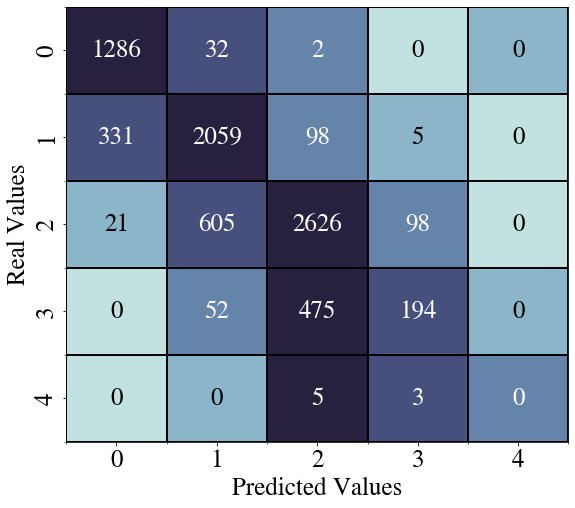

In [79]:
cm = metrics.confusion_matrix(df_final_supreme['CURB_real'], df_final_supreme['CURB_pred'])

label_classes = ['0', '1', '2', '3', '4']
cm_df_ = pd.DataFrame(cm, index = label_classes, columns = label_classes)
cm_df = 100*cm_df_ / len(df_final_supreme['CURB_real'])

b = np.argsort(np.argsort(cm, axis=1), axis=1)

plt.figure(figsize=(9,8))
c_map = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
im = plt.imshow(b, aspect="auto", cmap=c_map)
#'plt.colorbar(im, ticks=np.array([0.0, 0.5, 1.0])*b.max(), format=FixedFormatter(["small", "middle", "high"]))
ax = plt.gca()
# Major ticks
ax.set_xticks(np.arange(0, len(label_classes), 1))
ax.set_yticks(np.arange(0, len(label_classes), 1))

# Labels for major ticks
ax.set_xticklabels(label_classes, size = 25, ha = 'center')
ax.set_yticklabels(label_classes, size = 25, rotation = 90, va = 'center')

# Minor ticks
ax.set_xticks(np.arange(-0.5, len(label_classes), 1), minor=True)
ax.set_yticks(np.arange(-0.5, len(label_classes), 1), minor=True)

# Gridlines based on minor ticks
ax.grid(which='minor', color='k', linestyle='-', linewidth=2)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if b[i,j] >= int(len(label_classes)/2):
            plt.text(j,i,cm[i,j], ha="center", va="center", fontsize = 25, color  = 'w')
        else:
            plt.text(j,i,cm[i,j], ha="center", va="center", fontsize = 25)
plt.ylabel('Real Values', fontsize = 25)
plt.xlabel('Predicted Values', fontsize = 25)
#plt.title(scaling + " "+ technique, fontsize = 30)
#plt.savefig("Plots/cm_ForecastingFeatures"+scaling+"_"+technique+"_CURB.png", transparent = True, bbox_inches = "tight")
plt.show()

In [80]:
df_cm_temp = pd.DataFrame(cm, columns =['0','1','2','3','4'])
df_cm_temp['type'] = 'Supreme'
df_cm = pd.concat([df_cm, df_cm_temp])
df_cm.to_csv('cm_results.csv')

,0,1,2,3,4,type
0,1266,52,2,0,0,local_GRU
1,140,2250,103,0,0,local_GRU
2,5,264,2925,156,0,local_GRU
3,0,2,463,256,0,local_GRU
4,0,0,3,4,1,local_GRU
0,1277,43,0,0,0,local_LSTM
1,146,2255,92,0,0,local_LSTM
2,6,300,2936,108,0,local_LSTM
3,0,3,509,209,0,local_LSTM
4,0,0,4,3,1,local_LSTM
